# I.Phân loại hình ảnh
Xây dựng mô hình phân loại cho dữ liệu ảnh và văn bản sử dụng mạng CNN.
Một trong những mô hình mạng CNN đầu tiên và nổi bật đó là NeNet model

# A.Bộ dữ liệu MNIST
Mô hình phân loại văn bản sử dụng LeNet được xây dựng trên tập dữ liệu phân loại chữ số MNIST, với 70.000 ảnh và nhãn tương ứng thuộc 10 classes từ 0 đến 9

## 1.Tải về bộ dữ liệu

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06

/content/drive/MyDrive/Colab Notebooks/MODULE06


In [ ]:
# Import libs
import os
import random
import numpy as np
import torch
import torch .nn as nn
import torch . optim as optim
import torch .nn. functional as F
import torch . utils . data as data
import torchvision . transforms as transforms
import torchvision . datasets as datasets
from torchsummary import summary
import matplotlib . pyplot as plt
from PIL import Image
import time # Import the 'time' module

In [ ]:
# Download Data
ROOT = './data'
train_data = datasets . MNIST (
    root =ROOT ,
    train =True ,
    download = True
    )
test_data = datasets . MNIST (
    root =ROOT ,
    train =False ,
    download = True
    )

## 2.Tiền xử lý dữ liệu
- Chia tỉ lệ các tập training: validation = 0.9 : 0.1
- Chuẩn hoá dữ liệu và chuyển sang tensor sử dụng torchvison.transform

In [ ]:
# split training : validation = 0.9 : 0.1
VALID_RATIO = 0.9

n_train_examples = int( len( train_data ) * VALID_RATIO )
n_valid_examples = len( train_data ) - n_train_examples

train_data , valid_data = data . random_split (train_data , [ n_train_examples , n_valid_examples ])

# compute mean and std for normalization
mean = train_data . dataset . data . float (). mean () / 255
std = train_data . dataset . data . float ().std () / 255
train_transforms = transforms . Compose ([transforms . ToTensor () , transforms . Normalize ( mean =[ mean ], std =[ std ]) ])
test_transforms = transforms . Compose ([transforms . ToTensor () ,transforms . Normalize ( mean =[ mean ], std =[ std ])])

train_data . dataset . transform = train_transforms
valid_data . dataset . transform = test_transforms

# Create dataloader
BATCH_SIZE = 256
train_dataloader = data . DataLoader (train_data ,shuffle =True, batch_size = BATCH_SIZE)
valid_dataloader = data . DataLoader (valid_data ,batch_size = BATCH_SIZE)

## 3.Xây dựng mô hình LeNet

In [ ]:
class LeNetClassifier (nn. Module ):
  def __init__ (self , num_classes ):
    super (). __init__ ()
    self . conv1 = nn. Conv2d (in_channels =1, out_channels =6, kernel_size =5, padding ='same')
    self . avgpool1 = nn. AvgPool2d ( kernel_size =2)
    self . conv2 = nn. Conv2d ( in_channels =6, out_channels =16 , kernel_size =5)
    self . avgpool2 = nn. AvgPool2d ( kernel_size =2)
    self . flatten = nn. Flatten ()
    self . fc_1 = nn. Linear (16 * 5 * 5, 120)
    self . fc_2 = nn. Linear (120 , 84)
    self . fc_3 = nn. Linear (84 , num_classes )

  def forward (self , inputs ):
    outputs = self . conv1 ( inputs )
    outputs = self . avgpool1 ( outputs )
    outputs = F. relu ( outputs )
    outputs = self . conv2 ( outputs )
    outputs = self . avgpool2 ( outputs )
    outputs = F. relu ( outputs )
    outputs = self . flatten ( outputs )
    outputs = self . fc_1 ( outputs )
    outputs = self . fc_2 ( outputs )
    outputs = self . fc_3 ( outputs )
    return outputs

## 4.Huấn luyện mô hình

In [ ]:
# Training function
def train (model , optimizer , criterion , train_dataloader , device , epoch =0, log_interval=50):
  model . train ()
  total_acc , total_count = 0, 0
  losses = []
  start_time = time . time ()

  for idx , (inputs , labels ) in enumerate ( train_dataloader ):
    inputs = inputs .to( device )
    labels = labels .to( device )

    optimizer . zero_grad ()

    predictions = model ( inputs )

    # compute loss
    loss = criterion ( predictions , labels )
    losses . append ( loss . item ())

    # backward
    loss . backward ()
    torch .nn. utils . clip_grad_norm_ ( model . parameters () , 0.1)
    optimizer . step ()
    total_acc += ( predictions . argmax (1) == labels ). sum (). item ()
    total_count += labels . size (0)
    if idx % log_interval == 0 and idx > 0:
      elapsed = time . time () - start_time
      print ("|epoch {:3d} | {:5d}/{:5d} batches ""| accuracy {:8.3f}". format (epoch , idx , len ( train_dataloader ), total_acc / total_count))
      total_acc , total_count = 0, 0
      start_time = time . time ()

  epoch_acc = total_acc / total_count
  epoch_loss = sum( losses ) / len ( losses )
  return epoch_acc , epoch_loss


In [ ]:
# Evaluation function
def evaluate (model , criterion , valid_dataloader ):
  model . eval ()
  total_acc , total_count = 0, 0
  losses = []

  with torch . no_grad ():
    for idx , (inputs , labels ) in enumerate ( valid_dataloader ):
      inputs = inputs .to( device )
      labels = labels .to( device )
      predictions = model ( inputs )
      loss = criterion ( predictions , labels )
      losses . append ( loss . item ())
      total_acc += ( predictions . argmax (1) == labels ). sum (). item ()
      total_count += labels . size (0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum( losses ) / len ( losses )
  return epoch_acc , epoch_loss

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/MODULE06'

In [ ]:
# Training
num_classes = len( train_data . dataset . classes )

device = torch . device ('cuda' if torch . cuda . is_available () else 'cpu')

lenet_model = LeNetClassifier ( num_classes )
lenet_model .to( device )

criterion = torch .nn. CrossEntropyLoss ()
optimizer = optim . Adam ( lenet_model . parameters ())

num_epochs = 10
save_model = './model'

train_accs , train_losses = [], []
eval_accs , eval_losses = [], []
best_loss_eval = 100

for epoch in range (1, num_epochs +1) :
  epoch_start_time = time . time ()

  # Training
  train_acc , train_loss = train ( lenet_model , optimizer , criterion , train_dataloader ,device , epoch )
  train_accs . append ( train_acc )
  train_losses . append ( train_loss )

  # Evaluation
  eval_acc , eval_loss = evaluate ( lenet_model , criterion , valid_dataloader )
  eval_accs . append ( eval_acc )
  eval_losses . append ( eval_loss )

  # Save best model
  if eval_loss < best_loss_eval :
    torch . save ( lenet_model . state_dict () , save_model + '/lenet_model.pt')

  # Print loss , acc end epoch
  print ("-" * 59)
  print("| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss{:8.3f} ""| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ". format (   epoch , time . time () - epoch_start_time , train_acc , train_loss , eval_acc ,eval_loss))
  print ("-" * 59)

  # Load best model
  lenet_model . load_state_dict ( torch . load ( save_model + '/lenet_model.pt'))
  lenet_model . eval ()

|epoch   1 |    50/  211 batches | accuracy    0.668
|epoch   1 |   100/  211 batches | accuracy    0.893
|epoch   1 |   150/  211 batches | accuracy    0.922
|epoch   1 |   200/  211 batches | accuracy    0.945
-----------------------------------------------------------
| End of epoch   1 | Time : 31.13s | Train Accuracy    0.951 | Train Loss   0.485 | Valid Accuracy    0.949 | Valid Loss    0.176 
-----------------------------------------------------------


<ipython-input-16-d3793e0a9ed7>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model . load_state_dict ( torch . load ( save_model + '/lenet_model.pt'))


|epoch   2 |    50/  211 batches | accuracy    0.956
|epoch   2 |   100/  211 batches | accuracy    0.958
|epoch   2 |   150/  211 batches | accuracy    0.965
|epoch   2 |   200/  211 batches | accuracy    0.966
-----------------------------------------------------------
| End of epoch   2 | Time : 30.99s | Train Accuracy    0.965 | Train Loss   0.127 | Valid Accuracy    0.965 | Valid Loss    0.121 
-----------------------------------------------------------
|epoch   3 |    50/  211 batches | accuracy    0.968
|epoch   3 |   100/  211 batches | accuracy    0.969
|epoch   3 |   150/  211 batches | accuracy    0.971
|epoch   3 |   200/  211 batches | accuracy    0.976
-----------------------------------------------------------
| End of epoch   3 | Time : 31.83s | Train Accuracy    0.969 | Train Loss   0.095 | Valid Accuracy    0.971 | Valid Loss    0.091 
-----------------------------------------------------------
|epoch   4 |    50/  211 batches | accuracy    0.975
|epoch   4 |   100/  

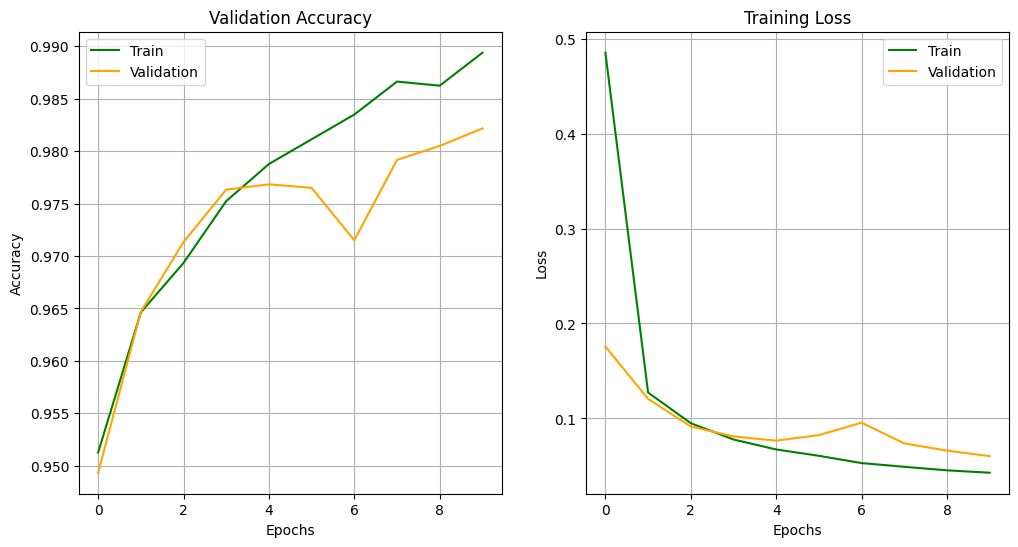

In [ ]:
#  trực quan kết quả huấn luyện trên tập train và val cho bài toán nonlinear data classification
fig , ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_accs, color='green')
ax[0].plot(eval_accs, color='orange')
ax[0].set(xlabel='Epochs', ylabel='Accuracy')
ax[0].set_title('Validation Accuracy')
ax[0].grid(True)
ax[0].legend(['Train', 'Validation'])

ax[1].plot(train_losses, color='green')
ax[1].plot(eval_losses, color='orange')
ax[1].set(xlabel='Epochs', ylabel='Loss')
ax[1].set_title('Training Loss')
ax[1].grid(True)
ax[1].legend(['Train', 'Validation'])


plt.show()

## 5.Đánh giá mô hình trên tập test


In [ ]:
test_data . transform = test_transforms
test_dataloader = data . DataLoader (test_data ,batch_size = BATCH_SIZE)
test_acc , test_loss = evaluate ( lenet_model , criterion , test_dataloader )
test_acc , test_loss

(0.987, 0.04054672578931786)

# B.Bộ dữ liệu Cassava Leaf Disease
xây dựng mô hình phân loại cho bộ dữ liệu Cassava Leaf Disease với các ảnh được gán nhãn và phân loại vào 5 lớp

## 1.Tải về bộ dữ liệu

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06

/content/drive/MyDrive/Colab Notebooks/MODULE06


In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O ./data/cassavaleafdata.zip
!unzip ./data/cassavaleafdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
  infla

In [ ]:
# Import libs
import os
import random
import numpy as np
import torch
import torch .nn as nn
import torch . optim as optim
import torch .nn. functional as F
import torch . utils . data as data
import torchvision . transforms as transforms
import torchvision . datasets as datasets
from torchsummary import summary
import matplotlib . pyplot as plt
from PIL import Image
import time

## 2.Tiền xử lý dữ liệu

In [ ]:
data_paths = {'train':'./cassavaleafdata/train','valid':'./cassavaleafdata/validation','test':'./cassavaleafdata/test'}

# load image from path
def loader ( path ):
  return Image . open ( path )

img_size = 150
train_transforms = transforms . Compose ([transforms . Resize ((150 , 150) ),transforms . ToTensor () ,])
train_data = datasets . ImageFolder (root = data_paths ['train'],loader =loader ,transform = train_transforms)
valid_data = datasets . ImageFolder (root = data_paths ['valid'],transform = train_transforms)
test_data = datasets . ImageFolder (root = data_paths ['test'],transform = train_transforms)

# Create dataloader
BATCH_SIZE = 256
train_dataloader = data . DataLoader (train_data ,shuffle =True, batch_size = BATCH_SIZE)
valid_dataloader = data . DataLoader (valid_data ,batch_size = BATCH_SIZE)
test_dataloader = data . DataLoader (test_data ,batch_size = BATCH_SIZE)

## 3.Xây dựng mô hình

In [ ]:
class LeNetClassifier (nn. Module ):
  def __init__ (self , num_classes ):
    super (). __init__ ()
    self . conv1 = nn. Conv2d (in_channels =3, out_channels =6, kernel_size =5, padding ='same')
    self . avgpool1 = nn. AvgPool2d ( kernel_size =2)
    self . conv2 = nn. Conv2d ( in_channels =6, out_channels =16 , kernel_size =5)
    self . avgpool2 = nn. AvgPool2d ( kernel_size =2)
    self . flatten = nn. Flatten ()
    self . fc_1 = nn. Linear (16 * 35 * 35, 120)
    self . fc_2 = nn. Linear (120 , 84)
    self . fc_3 = nn. Linear (84 , num_classes )

  def forward (self , inputs ):
    outputs = self . conv1 ( inputs )
    outputs = self . avgpool1 ( outputs )
    outputs = F. relu ( outputs )
    outputs = self . conv2 ( outputs )
    outputs = self . avgpool2 ( outputs )
    outputs = F. relu ( outputs )
    outputs = self . flatten ( outputs )
    outputs = self . fc_1 ( outputs )
    outputs = self . fc_2 ( outputs )
    outputs = self . fc_3 ( outputs )
    return outputs

## 4.Huấn luyện mô hình

In [ ]:
# Training function
def train (model , optimizer , criterion , train_dataloader , device , epoch =0, log_interval=50) :
  model . train ()
  total_acc , total_count = 0, 0
  losses = []
  start_time = time . time ()

  for idx , (inputs , labels ) in enumerate ( train_dataloader ):
    inputs = inputs .to( device )
    labels = labels .to( device )
    optimizer . zero_grad ()
    predictions = model ( inputs )

    # compute loss
    loss = criterion ( predictions , labels )
    losses . append ( loss . item ())

    # backward
    loss . backward ()
    torch .nn. utils . clip_grad_norm_ ( model . parameters () , 0.1)
    optimizer . step ()
    total_acc += ( predictions . argmax (1) == labels ). sum (). item ()
    total_count += labels . size (0)

    if idx % log_interval == 0 and idx > 0:
      elapsed = time . time () - start_time
      print ("|epoch {:3d}|{:5d}/{:5d}batches""| accuracy {:8.3f}". format (epoch , idx , len ( train_dataloader ), total_acc / total_count))

      total_acc , total_count = 0, 0
      start_time = time . time ()

  epoch_acc = total_acc / total_count
  epoch_loss = sum( losses ) / len ( losses )

  return epoch_acc , epoch_loss

In [ ]:
# Evaluation function
def evaluate (model , criterion , valid_dataloader ):
  model . eval ()
  total_acc , total_count = 0, 0
  losses = []

  with torch . no_grad ():
    for idx , (inputs , labels ) in enumerate ( valid_dataloader ):
      inputs = inputs .to( device )
      labels = labels .to( device )

      predictions = model ( inputs )

      loss = criterion ( predictions , labels )
      losses . append ( loss . item ())

      total_acc += ( predictions . argmax (1) == labels ). sum (). item ()
      total_count += labels . size (0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum( losses ) / len ( losses )
  return epoch_acc , epoch_loss

In [ ]:
# Training Model
num_classes = len( train_data . classes )

device = torch . device ('cuda' if torch . cuda . is_available () else 'cpu')

lenet_model = LeNetClassifier ( num_classes )
lenet_model .to( device )

criterion = torch .nn. CrossEntropyLoss ()
learning_rate = 2e-4
optimizer = optim . Adam ( lenet_model . parameters () , learning_rate )

num_epochs = 10
save_model = './model'

train_accs , train_losses = [], []
eval_accs , eval_losses = [], []
best_loss_eval = 100


In [ ]:

for epoch in range (1, num_epochs +1) :
  epoch_start_time = time . time ()

  # Training
  train_acc , train_loss = train ( lenet_model , optimizer , criterion , train_dataloader , device , epoch , log_interval =10)
  train_accs . append ( train_acc )
  train_losses . append ( train_loss )

  # Evaluation
  eval_acc , eval_loss = evaluate ( lenet_model , criterion , valid_dataloader )
  eval_accs . append ( eval_acc )
  eval_losses . append ( eval_loss )

  # Save best model
  if eval_loss < best_loss_eval :
    torch . save ( lenet_model . state_dict () , save_model + '/lenet_model.pt')

  # Print loss , acc end epoch
  print ("-" * 59)
  print ("|End of epoch {:3d}|Time: {:5.2f}s |Train Accuracy {:8.3f} |Train Loss{:8.3f} |Valid Accuracy {:8.3f} |Valid Loss {:8.3f} ". format (epoch , time . time () - epoch_start_time , train_acc , train_loss , eval_acc ,eval_loss))
  print ("-" * 59)

  # Load best model
  lenet_model . load_state_dict ( torch . load ( save_model + '/lenet_model.pt'))
  lenet_model . eval ()

|epoch   1|   10/   23batches| accuracy    0.431
|epoch   1|   20/   23batches| accuracy    0.481
-----------------------------------------------------------
|End of epoch   1|Time: 2370.02s |Train Accuracy    0.436 |Train Loss   1.375 |Valid Accuracy    0.470 |Valid Loss    1.458 
-----------------------------------------------------------


<ipython-input-14-db06abafa00d>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model . load_state_dict ( torch . load ( save_model + '/lenet_model.pt'))


|epoch   2|   10/   23batches| accuracy    0.472
|epoch   2|   20/   23batches| accuracy    0.476
-----------------------------------------------------------
|End of epoch   2|Time: 185.67s |Train Accuracy    0.429 |Train Loss   1.333 |Valid Accuracy    0.483 |Valid Loss    1.430 
-----------------------------------------------------------
|epoch   3|   10/   23batches| accuracy    0.486
|epoch   3|   20/   23batches| accuracy    0.500
-----------------------------------------------------------
|End of epoch   3|Time: 198.13s |Train Accuracy    0.468 |Train Loss   1.294 |Valid Accuracy    0.517 |Valid Loss    1.382 
-----------------------------------------------------------
|epoch   4|   10/   23batches| accuracy    0.515
|epoch   4|   20/   23batches| accuracy    0.493
-----------------------------------------------------------
|End of epoch   4|Time: 191.39s |Train Accuracy    0.479 |Train Loss   1.278 |Valid Accuracy    0.513 |Valid Loss    1.397 
----------------------------------

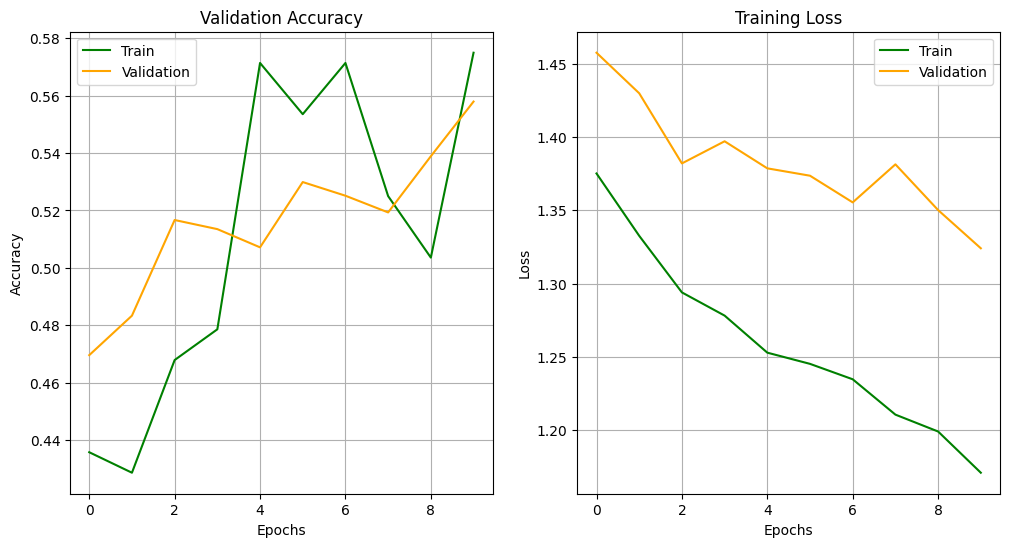

In [ ]:
#  trực quan kết quả huấn luyện trên tập train và val cho bài toán nonlinear data classification
fig , ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_accs, color='green')
ax[0].plot(eval_accs, color='orange')
ax[0].set(xlabel='Epochs', ylabel='Accuracy')
ax[0].set_title('Validation Accuracy')
ax[0].grid(True)
ax[0].legend(['Train', 'Validation'])

ax[1].plot(train_losses, color='green')
ax[1].plot(eval_losses, color='orange')
ax[1].set(xlabel='Epochs', ylabel='Loss')
ax[1].set_title('Training Loss')
ax[1].grid(True)
ax[1].legend(['Train', 'Validation'])


plt.show()

## 5.Đánh giá mô hình

In [ ]:
test_acc , test_loss = evaluate ( lenet_model , criterion , test_dataloader )
test_acc , test_loss

(0.5559681697612732, 1.3144198283553123)

# II.Phân loại văn bản
Trong phần này chúng ta xây dựng mô hình phân loại văn bản sử dụng kiến trúc mạng TextCNN trên bộ dữ liệu NTC-SCV

## 1.Tải về bộ dữ liệu

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06

/content/drive/MyDrive/Colab Notebooks/MODULE06


In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 17.93 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_test/test/pos/10000.txt  
  inflating: ./data/data_test/test/pos/10018.txt  
  inflating: ./data/data_test/test/pos/10020.txt  
  inflating: ./data/data_test/test/pos/10021.txt  
  inflating: ./data/data_test/test/pos/10031.txt  
  inflating: ./data/data_test/test/pos/10042.txt  
  inflating: ./data/data_test/test/pos/10047.txt  
  inflating: ./data/data_test/test/pos/10070.txt  
  inflating: ./data/data_test/test/pos/10075.txt  
  inflating: ./data/data_test/test/pos/10080.txt  
  inflating: ./data/data_test/test/pos/10083.txt  
  inflating: ./data/data_test/test/pos/10091.txt  
  inflating: ./data/data_test/test/pos/10099.txt  
  inflating: ./data/data_test/test/pos/1010.txt  
  inflating: ./data/data_test/test/pos/10103.txt  
 extracting: ./data/data_test/test/pos/10109.txt  
  inflating: ./data/data_test/test/pos/10110.txt  
  inflating: ./data/data_test/test/pos/10134.txt  
  inflating: ./data/data_test/te

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/MODULE06'

In [ ]:
!unzip ./ntc-scv/data/data_train.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [ ]:
!rm -rf ./ntc-scv

In [ ]:
# load data from paths to dataframe
import os
import pandas as pd
def load_data_from_path ( folder_path ):
  examples = []
  for label in os. listdir ( folder_path ):
    full_path = os. path . join ( folder_path , label )

    for file_name in os. listdir ( full_path ):
      file_path = os. path . join ( full_path , file_name )
      with open ( file_path , "r", encoding ="utf-8") as f:
        lines = f. readlines ()

      sentence = " ". join ( lines )
      if label == "neg":
        label = 0
      if label == "pos":
        label = 1

      data = {'sentence': sentence ,'label': label}
      examples . append ( data )
  return pd. DataFrame ( examples )

folder_paths = {'train':'./data/data_train/train','valid':'./data/data_train/test','test':'./data/data_test/test'}
train_df = load_data_from_path ( folder_paths ['train'])
valid_df = load_data_from_path ( folder_paths ['valid'])
test_df = load_data_from_path ( folder_paths ['test'])



In [ ]:
train_df.shape , valid_df.shape , test_df.shape

((30000, 2), (10000, 2), (10000, 2))

## 2.Tiền xử lý dữ liệu
Với bộ dữ liệu NTC-SCV có một số bình luận viết bằng tiếng anh hoặc tiếng pháp và chứ các thẻ HTML, đường dẫn URLs

In [ ]:
# Install library
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=6080184bb314b2ff896031e410390d0bc7d22a170ac0e31643acd894c6f46fe8
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


### Xoá bỏ những bình luận không phải tiếng việt

In [ ]:
#Xoá bỏ những bình luận không phải tiếng việt
from langid.langid import LanguageIdentifier , model

def identify_vn(df):
  identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
  not_vi_idx = set()
  THRESHOLD = 0.9

  for idx, row in df.iterrows():
    score = identifier.classify(row["sentence"])
    if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
      not_vi_idx.add(idx)

  vi_df = df[~df.index.isin(not_vi_idx)]
  not_vi_df = df[df.index.isin(not_vi_idx)]

  return vi_df , not_vi_df

train_df_vi, train_df_other = identify_vn(train_df)

### Làm sạch dữ liệu
Các bước tiền làm sạch liệu:
* Xoá bỏ thẻ HTML, đường dẫn URL
* Xoá bỏ dấu câu, số
* Xoá bỏ các ký tự đặc biệt, emoticons,...
* Chuẩn hoá khoảng trắng
* Chuyển sang viết thường

In [ ]:
import re
import string

def preprocess_text ( text ):
  url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
  text = url_pattern.sub(r" ", text)
  html_pattern = re.compile(r'<[^<>]+>')
  text = html_pattern.sub(" ", text)

  replace_chars = list(string.punctuation + string.digits)
  for char in replace_chars:
    text = text.replace(char," ")

  emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" # emoticons
                               u"\U0001F300-\U0001F5FF" # symbols & pictographs
                               u"\U0001F680-\U0001F6FF" # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                               u"\U0001F1F2-\U0001F1F4" # Macau flag
                               u"\U0001F1E6-\U0001F1FF" # flags
                               u"\U0001F600-\U0001F64F"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U0001F1F2"
                               u"\U0001F1F4"
                               u"\U0001F620"
                               u"\u200d"
                               u"\u2640-\u2642"
                               "]+", flags =re.UNICODE)

  text = emoji_pattern.sub(r" ", text)
  text = " ". join ( text . split ())

  return text . lower ()



In [ ]:
preprocess_text('Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer')

'thứ nào ta cùng quẩy vuvuzela beer'

In [ ]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-151-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [ ]:
train_df_vi.shape , valid_df.shape , test_df.shape

((29736, 3), (10000, 3), (10000, 3))

In [ ]:
train_df_vi.head()

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...


In [ ]:
train_df_vi.describe()

,label
count,29736.000000
mean,0.499361
std,0.500008
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 3.Biểu diễn văn bản thành vector
Để biểu diễn dữ liệu văn bản thành các đặc trưng (vectors), chúng ta sử dụng thư viện torchtext

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
# word - based tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer ("basic_english")

# create iter dataset
def yield_tokens ( sentences , tokenizer ):
  for sentence in sentences :
    yield tokenizer ( sentence )

# build vocabulary
from torchtext . vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator (yield_tokens ( train_df_vi ['preprocess_sentence'], tokenizer ),
                                        max_tokens = vocab_size ,
                                        specials =["<pad>", "<unk>"])

vocabulary . set_default_index ( vocabulary ["<unk>"])

# convert iter into torchtext dataset
from torchtext . data . functional import to_map_style_dataset
def prepare_dataset (df):
  for index , row in df. iterrows ():
    sentence = row['preprocess_sentence']
    encoded_sentence = vocabulary ( tokenizer ( sentence ))
    label = row['label']
    yield encoded_sentence , label

train_dataset = prepare_dataset ( train_df_vi )
train_dataset = to_map_style_dataset ( train_dataset )

valid_dataset = prepare_dataset ( valid_df )
valid_dataset = to_map_style_dataset ( valid_dataset )

test_dataset = prepare_dataset ( test_df )
test_dataset = to_map_style_dataset ( test_dataset )

In [ ]:
vocabulary.__len__()

10000

In [ ]:
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of valid_dataset: {len(valid_dataset)}")
print(f"Length of test_dataset: {len(test_dataset)}")

Length of train_dataset: 29736
Length of valid_dataset: 10000
Length of test_dataset: 10000


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch ( batch ):
  # create inputs , offsets , labels for batch
  encoded_sentences , labels = [], []
  for encoded_sentence , label in batch :
    labels . append ( label )
    encoded_sentence = torch . tensor ( encoded_sentence , dtype = torch . int64 )
    encoded_sentences . append ( encoded_sentence )

  labels = torch . tensor (labels , dtype = torch . int64 )
  encoded_sentences = pad_sequence (encoded_sentences ,padding_value = vocabulary ["<pad>"])

  return encoded_sentences , labels

batch_size = 128

# Check the length of train_dataset before creating DataLoader
print(f"Length of train_dataset: {len(train_dataset)}")

train_dataloader = DataLoader (train_dataset ,batch_size = batch_size ,shuffle =True ,collate_fn = collate_batch)
valid_dataloader = DataLoader (valid_dataset ,batch_size = batch_size ,shuffle =False ,collate_fn = collate_batch)
test_dataloader = DataLoader (test_dataset ,batch_size = batch_size ,shuffle =False ,collate_fn = collate_batch)

Length of train_dataset: 29736


In [ ]:
train_dataloader

## 4.Xây dựng mô hình TextCNN

In [ ]:
import torch.nn as nn # Import the necessary module
import torch.nn.functional as F # Import the necessary module

class TextCNN (nn. Module ):
  def __init__ (self ,vocab_size , embedding_dim , kernel_sizes , num_filters , num_classes ):
    super ( TextCNN , self ). __init__ ()
    self . vocab_size = vocab_size
    self . embedding_dim = embedding_dim
    self . kernel_sizes = kernel_sizes
    self . num_filters = num_filters
    self . num_classes = num_classes
    self . embedding = nn. Embedding ( vocab_size , embedding_dim , padding_idx =0)
    self . conv = nn. ModuleList ([nn. Conv1d (
                                    in_channels = embedding_dim
                                    ,out_channels = num_filters
                                    ,kernel_size =k
                                    ,stride =1) for k in kernel_sizes ])
    self .fc = nn. Linear ( len( kernel_sizes ) * num_filters , num_classes )

  def forward (self , x):
    batch_size , sequence_length = x. shape
    x = self . embedding (x.T). transpose (1, 2)
    #x = self.embedding(x)  # Apply embedding directly to x
    #x = x.permute(0, 2, 1) # Permute to (batch_size, embedding_dim, sequence_length)

    x = [F. relu ( conv (x)) for conv in self . conv ]
    x = [F. max_pool1d (c, c. size ( -1)). squeeze (dim = -1) for c in x]
    x = torch . cat(x, dim =1)
    x = self .fc(x)
    return x

## 5.Huấn luyện mô hình

In [ ]:
# Training
import time

def train (model , optimizer , criterion , train_dataloader , device , epoch =0, log_interval=50) :
  model . train ()
  total_acc , total_count = 0, 0
  losses = []
  start_time = time . time ()

  for idx , (inputs , labels ) in enumerate ( train_dataloader ):
    inputs = inputs .to( device )
    labels = labels .to( device )

    # zero grad
    optimizer . zero_grad ()

    # predictions
    predictions = model ( inputs )

    # compute loss\
    loss = criterion ( predictions , labels )
    losses . append ( loss . item ())

    # backward
    loss . backward ()
    optimizer . step ()
    total_acc += ( predictions . argmax (1) == labels ). sum (). item ()
    total_count += labels . size (0)

    if idx % log_interval == 0 and idx > 0:
      elapsed = time . time () - start_time
      print("|epoch{:3d}|{:5d}/{:5d}batches|accuracy{:8.3f}".format(epoch, idx, len(train_dataloader),total_acc/total_count))
      total_acc , total_count = 0, 0
      start_time = time . time ()

  epoch_acc = total_acc / total_count
  epoch_loss = sum( losses ) / len ( losses )
  return epoch_acc , epoch_loss



In [ ]:
# Evaluation
def evaluate (model , criterion , valid_dataloader ):
  model . eval ()
  total_acc , total_count = 0, 0
  losses = []
  with torch . no_grad ():
    for idx , (inputs , labels ) in enumerate ( valid_dataloader ):
      inputs = inputs .to( device )
      labels = labels .to( device )

      # predictions
      predictions = model ( inputs )

      # compute loss
      loss = criterion ( predictions , labels )
      losses . append ( loss . item ())

      total_acc += ( predictions . argmax (1) == labels ). sum (). item ()
      total_count += labels . size (0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum( losses ) / len ( losses )

  return epoch_acc , epoch_loss

In [ ]:
# prompt: size of train_dataloader

print(len(train_dataloader))
print(len(valid_dataloader))
print(len(test_dataloader))

233
79
79


In [ ]:
vocabulary.__len__()

10000

In [ ]:
# Huấn luyện mô hình
num_class = 2
vocab_size = len( vocabulary )
embedding_dim = 100
device = torch . device ("cuda" if torch . cuda . is_available () else "cpu")
model = TextCNN (vocab_size = vocab_size
                 ,embedding_dim = embedding_dim
                 ,kernel_sizes =[3 , 4, 5]
                 ,num_filters =100
                 ,num_classes =2)
model .to( device )

criterion = torch .nn. CrossEntropyLoss ()
optimizer = torch . optim . Adam ( model . parameters ())

num_epochs = 10
save_model = './model'

train_accs , train_losses = [], []
eval_accs , eval_losses = [], []
best_loss_eval = 100

for epoch in range (1, num_epochs +1) :
  epoch_start_time = time . time ()

  # Training
  train_acc, train_loss = train(model, optimizer, criterion, train_dataloader,device, epoch)
  train_accs . append ( train_acc )
  train_losses . append ( train_loss )

  # Evaluation
  eval_acc , eval_loss = evaluate (model , criterion , valid_dataloader )
  eval_accs . append ( eval_acc )
  eval_losses . append ( eval_loss )

  # Save best model
  if eval_loss < best_loss_eval :
    torch . save ( model . state_dict () , save_model + '/text_cnn_model.pt')

  # Print loss , acc end epoch
  print ("-" * 59)
  print ("|End of epoch{:3d}|Time:{:5.2f}s|Train Accuracy{:8.3f}|Train Loss{:8.3f}"
          "|Valid Accuracy{:8.3f}|Valid Loss{:8.3f}".format (
              epoch , time . time () - epoch_start_time , train_acc , train_loss , eval_acc ,eval_loss))
  print (" -" * 59)

  # Load best model
  model . load_state_dict ( torch . load ( save_model + '/text_cnn_model.pt'))
  model . eval ()


|epoch  1|   50/  233batches|accuracy   0.716
|epoch  1|  100/  233batches|accuracy   0.844
|epoch  1|  150/  233batches|accuracy   0.853
|epoch  1|  200/  233batches|accuracy   0.872
-----------------------------------------------------------
|End of epoch  1|Time:10.52s|Train Accuracy   0.869|Train Loss   0.394|Valid Accuracy   0.869|Valid Loss   0.322
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
|epoch  2|   50/  233batches|accuracy   0.913
|epoch  2|  100/  233batches|accuracy   0.914
|epoch  2|  150/  233batches|accuracy   0.916
|epoch  2|  200/  233batches|accuracy   0.910
-----------------------------------------------------------
|End of epoch  2|Time: 8.75s|Train Accuracy   0.908|Train Loss   0.239|Valid Accuracy   0.883|Valid Loss   0.290
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
|epoch  3|   50/  233batches|accuracy   0.958
|e

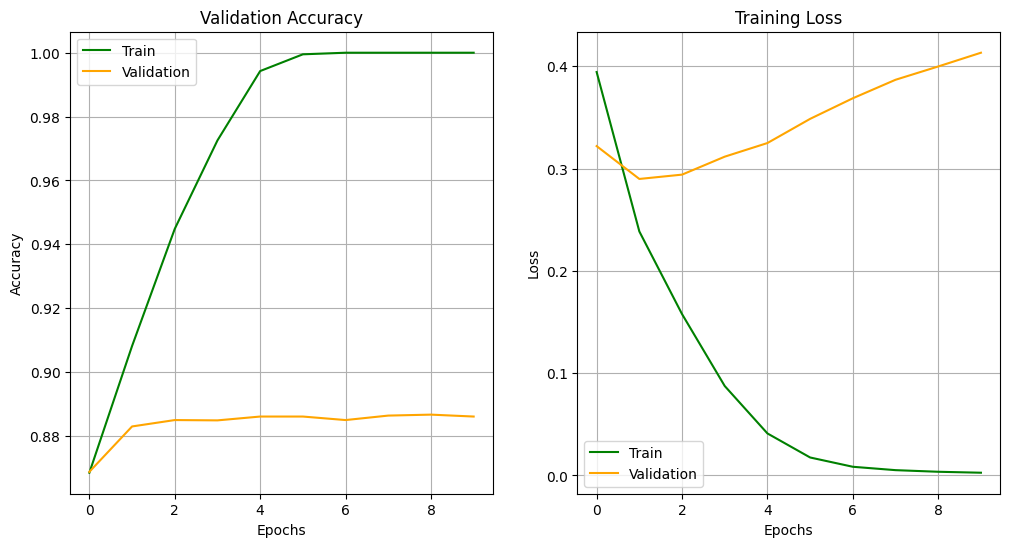

In [ ]:
#  trực quan kết quả huấn luyện trên tập train và val cho bài toán nonlinear data classification
fig , ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_accs, color='green')
ax[0].plot(eval_accs, color='orange')
ax[0].set(xlabel='Epochs', ylabel='Accuracy')
ax[0].set_title('Validation Accuracy')
ax[0].grid(True)
ax[0].legend(['Train', 'Validation'])

ax[1].plot(train_losses, color='green')
ax[1].plot(eval_losses, color='orange')
ax[1].set(xlabel='Epochs', ylabel='Loss')
ax[1].set_title('Training Loss')
ax[1].grid(True)
ax[1].legend(['Train', 'Validation'])


plt.show()

## 6.Đánh giá mô hình

In [ ]:
test_dataset = prepare_dataset ( test_df )
test_dataset = to_map_style_dataset ( test_dataset )
test_dataloader = DataLoader (test_dataset ,batch_size = batch_size ,shuffle =False ,collate_fn = collate_batch)
test_acc , test_loss = evaluate (model , criterion , valid_dataloader )
test_acc , test_loss

(0.8861, 0.41323392557664007)